------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.7.15


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [8]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm


## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [9]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2022-11-16 14:14:13--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.04s   

2022-11-16 14:14:13 (14.8 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2022-11-16 14:14:13--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [10]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

In [11]:
# Retrieve the words from a given part of the reviews

def retrieve_words(data):
  words = []
  for rev in data:
    for sentence in rev['content']:
      for word in sentence:
        words.append(word[0].lower())

  return words

In [12]:
# Retrieve all unique words for a given part of the reviews

def retrieve_unique_words(train):
  unique_words = []
  for rev in train:
    for sentence in rev['content']:
      for word in sentence:
        if word[0].lower() not in unique_words:
          unique_words.append(word[0].lower())
  return unique_words

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [15]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [23]:
from nltk.corpus.reader import wordlist

# Create a list of all the words in the file 'sent_lexicon'
words = []
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    start = line.find('word1')
    stop = line.find(" ",start)
    words.append(line[start+ 6:stop])

# Create a list of the polarity of each word in the file 'sent_lexicon'
priorpolarity = []
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    start = line.find('priorpolarity')
    stop = line.find(" ",start)
    priorpolarity.append(line[start+ 14:stop])

In [24]:
def classify_rev(reviews, priorpolarity, mag=None, avg_doc_length=None):
  result = []

  # Classify each review based on the sentiment of the words in the review
  for rev in reviews:
    pos_words = 0
    rev_pos = ''
    doc_length = 0
    for sentence in rev['content']:
      for word in sentence:
        if word[0].lower() in words:
          doc_length += 1

          # Find the polarity of the word
          index_word = words.index(word[0].lower())
          posneg = priorpolarity[index_word]

          # Change amount of positive words based on sentiment of evaluated word
          if mag:
            # Use the magnitude of the sentiment of each word
            strongweak = mag[index_word]
            if strongweak == 'weaksubj':
              if posneg == 'positive':
                pos_words += 1
              if posneg == 'negative':
                pos_words -= 1
            if strongweak == 'strongsubj':
              if posneg == 'positive':
                pos_words += 2
              if posneg == 'negative':
                pos_words -= 2
          else:
            if posneg == 'positive':
              pos_words += 1
            if posneg == 'negative':
              pos_words -= 1

    # Set a threshold for the amount of positive words
    if avg_doc_length:
      # Adjust the threshold based on the document length
      threshold = (doc_length / avg_doc_length) * 7.13
    elif mag:
      threshold = 10
    else:
      threshold = 7
    
    if pos_words > threshold:
      rev_pos = 'POS'
    else:
      rev_pos = 'NEG'

    if rev_pos == rev['sentiment']:
      result.append(1)
    else:
      result.append(0)
  return result

In [26]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
result = classify_rev(reviews,priorpolarity)

token_accuracy = sum(result) / len(result)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [19]:
# Find the magnitude of the sentiment of each word in the lexicon.
mag = []
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    start = line.find('type=')
    stop = line.find(" ",start)
    mag.append(line[start+ 5:stop])

In [21]:
# Find the average difference of sentiment score based on the word polarities

score_dif = []
for rev in reviews:
  pos_score, neg_score = 0, 0
  for sentence in rev['content']:
    for word in sentence:
      if word[0].lower() in words:
          # Find the polarity of the word
          index_word = words.index(word[0].lower())
          posneg = priorpolarity[index_word]
          strongweak = mag[index_word]
          if strongweak == 'weaksubj':
            if posneg == 'positive':
              pos_score += 1
            if posneg == 'negative':
              neg_score += 1
          if strongweak == 'strongsubj':
            if posneg == 'positive':
              pos_score += 2
            if posneg == 'negative':
              neg_score += 2
  score_dif.append(pos_score - neg_score)

avg_score = np.mean(score_dif)

print(avg_score)

10.517


In [27]:
result2 = classify_rev(reviews, priorpolarity, mag=mag)

magnitude_accuracy = sum(result2) / len(result2)
print("Accuracy: %0.3f" % token_accuracy)
print("Accuracy with the magnitude of the sentiment: %0.3f" % magnitude_accuracy)

Accuracy: 0.684
Accuracy with the magnitude of the sentiment: 0.688


#### (Q.1.3) Make a barplot of the two results (0.5pt)

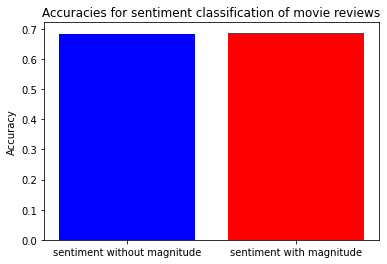

In [28]:
fig, ax = plt.subplots()

accuracies = ['sentiment without magnitude', 'sentiment with magnitude']
values= [token_accuracy, magnitude_accuracy]
bar_colors = ['blue', 'red']
ax.bar(accuracies, values, color=bar_colors)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracies for sentiment classification of movie reviews')

plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

The defined threshold is a minimum amount of 7 positive words. The difference in the amount of positive and negative words depends on the document length. For a document with an average length there will be on average 7 more positive words. If the document is longer than average the difference between the amount of positive words and negative words will on average be larger. This means that the treshold must be higher for a large document, and lower for a small document. Using a threshold of 7 more positive words can be a problem, since a very large document can contain only the minimum difference between the amount of positive and negative words to exceed the threshold, while in this large documents there should on average be more positive words to be classified as positive according to expected difference.

In [ ]:
doc_length_list = []

# Find the length of each review
for rev in reviews:
  doc_length = 0
  rev_pos = ''
  for sentence in rev['content']:
    for word in sentence:
      if word[0].lower() in words:
        doc_length += 1
  doc_length_list.append(doc_length)

# Calculate the average length of the reviews
avg_doc_length = np.mean(doc_length_list)
print(avg_doc_length)

98.0305


In [ ]:
result3 = classify_rev(reviews, priorpolarity, mag=mag, 
                       avg_doc_length=avg_doc_length)

accuracy = sum(result3) / len(result3)
print("Accuracy: %0.3f" % accuracy)

Accuracy: 0.669


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

If a word is skipped for one of the classes the overall probability does not change based on this word. Especially when a word is not seen in the entire class the probability should get lower when that word is observed. When skipping it for one class the probability does not change for that class while the probability of the other class gets smaller, because the probability of that word is used to calculate the overall probability for that class. This is a problem since the chance of classifying to the class where the words is not observed gets bigger than the chance of classifying to the other class in this case.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
# TRAINING DATA
train_data1 = reviews[:900]
test_data1 = reviews[900:1000]
train_data2 = reviews[1000:1900]
test_data2 = reviews[1900:]
train_data = train_data1 + train_data2
test_data = test_data1 + test_data2

# Find all the words in the positive training data
test_x_neg = [r['content'] for r in train_data2]
train_word_pos = []
for rev in test_x_neg:
  for sentence in rev:
    for word in sentence:
        train_word_pos.append(word[0].lower())

# Find all the words in the negative training data
test_x_pos = [r['content'] for r in train_data1]
train_word_neg = []
for rev in test_x_pos:
  for sentence in rev:
    for word in sentence:
        train_word_neg.append(word[0].lower())

In [ ]:
count_pos = Counter(train_word_pos)
count_neg = Counter(train_word_neg)
total_pos = sum(count_pos.values())
total_neg = sum(count_neg.values())

prob =[]
for rev in test_data:
  pr_pos = 0
  pr_neg = 0
  for sentence in rev['content']:
    for word in sentence:
      if word[0].lower() in count_pos.keys() and word[0].lower() in count_neg.keys():
        pr_pos += np.log(count_pos[word[0].lower()] / total_pos)
        pr_neg += np.log(count_neg[word[0].lower()] / total_neg)
  prob.append(np.argmax([pr_neg,pr_pos]))

test_y = [label['sentiment'] for label in test_data]
test_y_new = []
for i in test_y:
  if i == 'NEG':
    test_y_new.append(0)
  if i == 'POS':
    test_y_new.append(1)
sum(test_y_new)

result = []
for i in range(len(test_y_new)):
  if test_y_new[i] == prob[i]:
    result.append(1)
  else:
    result.append(0)

result =sum(result) / len(result)
print("Accuracy: %0.3f" % result)

Accuracy: 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

Accuracy is not good to evaulate the classification in a situation where 90% of the data instances are of positive movie reviews. If there is a strong imbalance in the amount of each class the accuracy gives a distorted result. For example, in the case that all the reviews (100%) are classified as positive while 90% is actually positive, the accuracy will be 90%. The accuracy is high while the classification of negative reviews is not working at all.

In [ ]:
train_data1 = reviews[:90]
test_data1 = reviews[900:910]
train_data2 = reviews[1000:1900]
test_data2 = reviews[1900:]
train_data = train_data1 + train_data2
test_data = test_data1 + test_data2

# Find all the words in the positive training data
test_x = [r['content'] for r in train_data2]
train_word_pos = []
for rev in test_x:
  for sentence in rev:
    for word in sentence:
        train_word_pos.append(word[0].lower())

# Find all the words in the positive training data
test_x = [r['content'] for r in train_data1]
train_word_neg = []
for rev in test_x:
  for sentence in rev:
    for word in sentence:
        train_word_neg.append(word[0].lower())

In [ ]:
count_pos = Counter(train_word_pos)
count_neg = Counter(train_word_neg)
total_pos = sum(count_pos.values())
total_neg = sum(count_neg.values())

prob =[]
for rev in test_data:
  #print(rev['sentiment'])
  pr_pos = 0
  pr_neg = 0
  for sentence in rev['content']:
    for word in sentence:
      if word[0].lower() in count_pos.keys() and word[0].lower() in count_neg.keys():
        pr_pos += np.log(count_pos[word[0].lower()] / total_pos) + np.log(0.9)
        pr_neg += np.log(count_neg[word[0].lower()] / total_neg) + np.log(0.1)
  prob.append(np.argmax([pr_neg,pr_pos]))

test_y = [label['sentiment'] for label in test_data]
test_y_new = []
for i in test_y:
  if i == 'NEG':
    test_y_new.append(0)
  if i == 'POS':
    test_y_new.append(1)
sum(test_y_new)

result = []
for i in range(len(test_y_new)):
  if test_y_new[i] == prob[i]:
    result.append(1)
  else:
    result.append(0)

result =sum(result) / len(result)
print("Accuracy: %0.3f" % result)

Accuracy: 0.909


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [ ]:
# YOUR CODE HERE

# TRAINING DATA
train_data1 = reviews[:900]
test_data1 = reviews[900:1000]
train_data2 = reviews[1000:1900]
test_data2 = reviews[1900:]
train_data = train_data1 + train_data2
test_data = test_data1 + test_data2

# TRAIN DATA POSITIVE
test_y = [label['sentiment'] for label in train_data2]
test_x = [r['content'] for r in train_data2]

# COUNT WORDS TRAINDATA POSITIVE
train_word_pos = []
for rev in test_x:
  for sentence in rev:
    for word in sentence:
        train_word_pos.append(word[0].lower())

# TRAIN DATA NEGATIVE
test_y = [label['sentiment'] for label in train_data1]
test_x = [r['content'] for r in train_data1]

# # COUNT WORDS TRAINDATA negative
train_word_neg = []
for rev in test_x:
  for sentence in rev:
    for word in sentence:
        train_word_neg.append(word[0].lower())

count_pos = Counter(train_word_pos)
count_neg = Counter(train_word_neg)
total_pos = sum(count_pos.values())
total_neg = sum(count_neg.values())
# TRAINING WORDS 
train_y = [label['sentiment'] for label in train_data]
train_x = [r['content'] for r in train_data]
train_words = []
for rev in train_x:
  for sentence in rev:
    for word in sentence:
      if word[0].lower() not in train_words:
        train_words.append(word[0].lower())

In [ ]:
prob = []
for rev in test_data:
  pr_pos = 0
  pr_neg = 0
  for sentence in rev['content']:
    for word in sentence:
        pr_pos += np.log((count_pos[word[0].lower()] + 1) / (total_pos + len(train_words)))
        pr_neg += np.log((count_neg[word[0].lower()] + 1) / (total_neg + len(train_words)))
  prob.append(np.argmax([pr_neg,pr_pos]))

print(prob)
test_y = [label['sentiment'] for label in test_data]
test_y_new = []
for i in test_y:
  if i == 'NEG':
    test_y_new.append(0)
  if i == 'POS':
    test_y_new.append(1)
sum(test_y_new)

result = []
for i in range(len(test_y_new)):
  if test_y_new[i] == prob[i]:
    result.append(1)
  else:
    result.append(0)

result =sum(result) / len(result)
print("Accuracy: %0.4f" % result)

[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Accuracy: 0.8250


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
xp0, xp1, xp2, xp3, xp4, xp5, xp6, xp7, xp8, xp9 = [], [], [], [], [], [], [], [], [], []
xn0, xn1, xn2, xn3, xn4, xn5, xn6, xn7, xn8, xn9 = [], [], [], [], [], [], [], [], [], []
y0, y1, y2, y3, y4, y5, y6, y7, y8, y9 = [], [], [], [], [], [], [], [], [], []

for i in range(len(reviews)):
  for mod in range(10):
    if (i - mod) % 10 == 0:
      eval('y' + str(mod)).append(reviews[i])
    else:
      # Reviews until element 999 are negative, above positive
      if i < 1000:
        eval('xn' + str(mod)).append(reviews[i])
      else:
        eval('xp' + str(mod)).append(reviews[i])

In [ ]:
acc_list = []

for i in range(10):

  train_pos = eval('xp' + str(i))
  train_neg = eval('xn' + str(i))
  train_data = train_pos + train_neg
  

  train_words_pos = retrieve_words(train_pos)
  train_words_neg = retrieve_words(train_neg)

  count_pos = Counter(train_words_pos)
  count_neg = Counter(train_words_neg)
  total_pos = sum(count_pos.values())
  total_neg = sum(count_neg.values())

  unique_words = retrieve_unique_words(train_data)
  prob = []

  for rev in eval('y' + str(i)):
    pr_pos = 0
    pr_neg = 0
    for sentence in rev['content']:
      for word in sentence:
          pr_pos += np.log((count_pos[word[0].lower()] + 1) / (total_pos + len(unique_words)))
          pr_neg += np.log((count_neg[word[0].lower()] + 1) / (total_neg + len(unique_words)))
    prob.append(np.argmax([pr_neg,pr_pos]))

  test_y = [label['sentiment'] for label in eval('y' + str(i))]
  test_y_new = []

  # Covert the sentiment result to 0 (negative) or 1 (positive)
  for i in test_y:
    if i == 'NEG':
      test_y_new.append(0)
    if i == 'POS':
      test_y_new.append(1)

  # Check if the review is correctly classified
  result = []
  for i in range(len(test_y_new)):
    if test_y_new[i] == prob[i]:
      result.append(1)
    else:
      result.append(0)

  accuracy =sum(result) / len(result)
  acc_list.append(accuracy)

0
1
2
3
4
5
6
7
8
9


In [ ]:
print('The accuracies for thhe different cycles:', acc_list)
print('Mean accuracy =', np.mean(acc_list))

[0.79, 0.835, 0.81, 0.83, 0.775, 0.85, 0.83, 0.78, 0.825, 0.845]
0.817


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance. 

In [ ]:
# YOUR CODE HERE
var = 1 / len(acc_list) * np.sum((np.array(acc_list) - np.mean(acc_list))**2)
print(var)
# The variance is very small. This indicates that the accuracy is similar
# between the different cycles, which means that the way the data is splitted
# doesn't have a big influence on the accuracy.

0.0006509999999999987


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [ ]:
stemmer = PorterStemmer()

acc_list2 = []

# Perform cross validation over the dataset
for i in range(10):

  train_pos = eval('xp' + str(i))
  train_neg = eval('xn' + str(i))
  train_data = train_pos + train_neg
  
  # Stem both lists of words
  train_words_pos = [stemmer.stem(w) for w in retrieve_words(train_pos)]
  train_words_neg = [stemmer.stem(w) for w in retrieve_words(train_neg)]

  count_pos = Counter(train_words_pos)
  count_neg = Counter(train_words_neg)
  total_pos = sum(count_pos.values())
  total_neg = sum(count_neg.values())

  unique_words = retrieve_unique_words(train_data)
  prob = []

  # Classify the reviews based on the occurences of the stemmed words
  for rev in eval('y' + str(i)):
    pr_pos = 0
    pr_neg = 0
    for sentence in rev['content']:
      for word in sentence:
          word = stemmer.stem(word[0].lower())
          pr_pos += np.log((count_pos[word] + 1) / (total_pos + len(unique_words)))
          pr_neg += np.log((count_neg[word] + 1) / (total_neg + len(unique_words)))
    prob.append(np.argmax([pr_neg,pr_pos]))

  test_y = [label['sentiment'] for label in eval('y' + str(i))]
  test_y_new = []

  # Covert the sentiment result to 0 (negative) or 1 (positive)
  for i in test_y:
    if i == 'NEG':
      test_y_new.append(0)
    if i == 'POS':
      test_y_new.append(1)

  # Check if the review is correctly classified
  result = []
  for i in range(len(test_y_new)):
    if test_y_new[i] == prob[i]:
      result.append(1)
    else:
      result.append(0)

  accuracy =sum(result) / len(result)
  acc_list2.append(accuracy)


0
1
2
3
4
5
6
7
8
9


In [ ]:
print('The accuracies for the different cycles:', acc_list2)
print('Mean accuracy =', np.mean(acc_list2))

[0.785, 0.84, 0.81, 0.855, 0.77, 0.84, 0.825, 0.78, 0.825, 0.84]
0.817


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# NOT USING STEMMING THEN VOCABULARY SIZE EQUAL TO TRAINING DATA

# TRAINING DATA
train_data1 = reviews[:900]
test_data1 = reviews[900:1000]
train_data2 = reviews[1000:1900]
test_data2 = reviews[1900:]
train_data = train_data1 + train_data2
test_data = test_data1 + test_data2

# Retrieve the unique word list for both the stemmed words an unstemmed words
withoutstemming = retrieve_unique_words(train_data)
withstemming = np.unique([stemmer.stem(w) for w in withoutstemming])

print('Number of features without stemming =', len(withoutstemming))
print('Number of features with stemming =', len(withstemming))


45348
32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [29]:
train_neg = reviews[:900]
test_neg = reviews[900:1000]
train_pos = reviews[1000:1900]
test_pos = reviews[1900:]
train_data = train_neg + train_pos
test_data = test_neg + test_pos

# Find vocabulary size of the training data
unique_words = retrieve_unique_words(train_data)
voc_size = len(unique_words)

In [30]:
from nltk.util import ngrams

train_words_pos = [w for w in retrieve_words(train_pos)]
train_words_neg = [w for w in retrieve_words(train_neg)]

all_bigrams_pos, all_bigrams_neg = [], []
all_trigrams_pos, all_trigrams_neg = [], []

for rev in train_pos:
  for sentence in rev['content']:
    sentence = np.array(sentence)
    sentence = sentence[:,0]
    bigrams_pos = list(ngrams(sentence, 2))
    trigrams_pos = list(ngrams(sentence, 3))
    for bigram in bigrams_pos:
      all_bigrams_pos.append(bigram)
    for trigram in trigrams_pos:
      all_trigrams_pos.append(trigram)

for rev in train_neg:
  for sentence in rev['content']:
    sentence = np.array(sentence)
    sentence = sentence[:,0]
    bigrams_neg = list(ngrams(sentence, 2))
    trigrams_neg = list(ngrams(sentence, 3))
    for bigram in bigrams_neg:
      all_bigrams_neg.append(bigram)
    for trigram in trigrams_neg:
      all_trigrams_neg.append(trigram)

# Create counters for unigrams
count_pos_uni = Counter(train_words_pos)
count_neg_uni = Counter(train_words_neg)
total_pos_uni = sum(count_pos_uni.values())
total_neg_uni = sum(count_neg_uni.values())

# Create counters for bigrams
count_pos_bi = Counter(all_bigrams_pos)
count_neg_bi = Counter(all_bigrams_neg)
total_pos_bi = sum(count_pos_bi.values())
total_neg_bi = sum(count_neg_bi.values())

# Create counters for trigrams
count_pos_tri = Counter(all_trigrams_pos)
count_neg_tri = Counter(all_trigrams_neg)
total_pos_tri = sum(count_pos_tri.values())
total_neg_tri = sum(count_neg_tri.values())

In [31]:
def n_gram_classifier(test_data, trigram=False):
  prob = []

  for rev in test_data:
    pr_pos = 0
    pr_neg = 0
    for sentence in rev['content']:
      sentence = np.array(sentence)
      sentence = sentence[:,0]
      unigrams = list(ngrams(sentence, 1))    
      bigrams = list(ngrams(sentence, 2))
      trigrams = list(ngrams(sentence, 3))

      for i in range(len(unigrams)):
          pr_pos += np.log((count_pos_uni[unigrams[i]] + 1) / (total_pos_uni + len(unique_words)))
          pr_neg += np.log((count_neg_uni[unigrams[i]] + 1) / (total_pos_uni + len(unique_words)))

      for i in range(len(bigrams)):
          pr_pos += np.log((count_pos_bi[bigrams[i]] + 1) / (count_pos_uni[bigrams[i][0]] + len(unique_words)))
          pr_neg += np.log((count_neg_bi[bigrams[i]] + 1) / (count_neg_uni[bigrams[i][0]] + len(unique_words)))
      if trigram == True:
          for i in range(len(trigrams)):
            pr_pos += np.log((count_pos_tri[trigrams[i]] + 1) / (count_pos_bi[trigrams[i][0:2]] + len(unique_words)))
            pr_neg += np.log((count_neg_tri[trigrams[i]] + 1) / (count_neg_bi[trigrams[i][0:2]] + len(unique_words)))


    prob.append(np.argmax([pr_neg,pr_pos]))

  test_y = [label['sentiment'] for label in test_data]
  test_y_new = []

  # Convert pos/neg to 1/0
  for i in test_y:
    if i == 'NEG':
      test_y_new.append(0)
    if i == 'POS':
      test_y_new.append(1)
  sum(test_y_new)

  result = []
  for i in range(len(test_y_new)):
    if test_y_new[i] == prob[i]:
      result.append(1)
    else:
      result.append(0)

  result = sum(result) / len(result)

  return result

In [32]:
result = n_gram_classifier(test_data, trigram=False)

print("Result for unigram + bigram")
print("Accuracy: %0.3f" % result)

Result for unigram + bigram
Accuracy: 0.790


In [33]:
result2 = n_gram_classifier(test_data, trigram=True)

print("Result for unigram + bigram")
print("Accuracy: %0.3f" % result2)

Result for unigram + bigram
Accuracy: 0.820



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


The vocabulary size of unigrams + bigrams = 532865
The vocabulary size of unigrams + bigrams + trigrams = 1519211

In [ ]:
# YOUR CODE HERE

all_words, all_bigrams, all_trigrams = [], [], []

for rev in reviews:
  for sentence in rev['content']:
    sentence = np.array(sentence)
    sentence = sentence[:,0]
    bigrams = list(ngrams(sentence, 2))
    trigrams = list(ngrams(sentence, 3))
    for word in sentence:
      all_words.append(word)
    for bigram in bigrams:
      all_bigrams.append(bigram)
    for trigram in trigrams:
      all_trigrams.append(trigram)

tot = len(set(all_words))
tot2 = len(set(all_bigrams))
tot3 = len(set(all_trigrams))

print(tot + tot2)
print(tot + tot2 + tot3)

532865
1519211


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
words_total = [w for w in retrieve_words(reviews)]
count_total = Counter(words_total)

In [ ]:
xp0, xp1, xp2, xp3, xp4, xp5, xp6, xp7, xp8, xp9 = [], [], [], [], [], [], [], [], [], []
xn0, xn1, xn2, xn3, xn4, xn5, xn6, xn7, xn8, xn9 = [], [], [], [], [], [], [], [], [], []
y0, y1, y2, y3, y4, y5, y6, y7, y8, y9 = [], [], [], [], [], [], [], [], [], []

for i in range(len(reviews)):
  for mod in range(10):
    if (i - mod) % 10 == 0:
      eval('y' + str(mod)).append(reviews[i])
    else:
      # Reviews until element 999 are negative, above positive
      if i < 1000:
        eval('xn' + str(mod)).append(reviews[i])
      else:
        eval('xp' + str(mod)).append(reviews[i])



In [ ]:
# YOUR CODE HERE
acc_list = []

for i in range(10):

  print(i)

  train_pos = eval('xp' + str(i))
  train_neg = eval('xn' + str(i))
  train_data = train_pos + train_neg

  x_values = []
  for rev in train_data:
    # SET EVERYTHING BACK TO 0
    count_total = dict.fromkeys(count_total, 0)
    # COUNT WORDS IN REVIEW
    for sentence in rev['content']:
      for word in sentence:
        count_total[word[0].lower()] += 1
    x_values.append(list(count_total.values()))

  X = x_values
  y = [label['sentiment'] for label in train_data]
  train_y_new = []
  for p in y:
    if p == 'NEG':
      train_y_new.append(0)
    if p == 'POS':
      train_y_new.append(1)
  clf = svm.SVC(kernel = 'linear')
  clf.fit(X, train_y_new) 

  #COUNT TEST DATA
  x_test_values = []
  for rev in eval('y' + str(i)):
    count_total = dict.fromkeys(count_total, 0)
    for sentence in rev['content']:
      for word in sentence:
        count_total[word[0].lower()] += 1
    x_test_values.append(list(count_total.values()))

  y_predict = clf.predict(x_test_values)   

  test_y = [label['sentiment'] for label in eval('y' + str(i))]
  test_y_new = []

  for i in test_y:
    if i == 'NEG':
      test_y_new.append(0)
    if i == 'POS':
      test_y_new.append(1)

  result = []
  for i in range(len(test_y_new)):
    if test_y_new[i] == y_predict[i]:
      result.append(1)
    else:
      result.append(0)

  accuracy =sum(result) / len(result)
  acc_list.append(accuracy)

0
1
2
3
4
5
6
7
8
9


In [ ]:
print(acc_list)
print(np.mean(acc_list))

0.837

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE
def retrieve_words_POS(data):
  words = []
  for rev in data:
    for sentence in rev['content']:
      for word in sentence:
        word1 = word[0].lower()
        words.append(word1+word[1])
  return words

In [ ]:
words_total = [w for w in retrieve_words_POS(reviews)]
count_total = Counter(words_total)

In [ ]:
# YOUR CODE HERE
acc_list = []

for i in range(10):

  print(i)

  train_pos = eval('xp' + str(i))
  train_neg = eval('xn' + str(i))
  train_data = train_pos + train_neg

  x_values = []
  for rev in train_data:
    # SET EVERYTHING BACK TO 0
    count_total = dict.fromkeys(count_total, 0)
    # COUNT WORDS IN REVIEW
    for sentence in rev['content']:
      for word in sentence:
        word1 = word[0].lower()
        combi = word1+word[1]
        count_total[combi] += 1
    x_values.append(list(count_total.values()))

  X = x_values
  y = [label['sentiment'] for label in train_data]
  train_y_new = []
  for p in y:
    if p == 'NEG':
      train_y_new.append(0)
    if p == 'POS':
      train_y_new.append(1)
  clf = svm.SVC(kernel = 'linear')
  clf.fit(X, train_y_new) 

  #COUNT TEST DATA
  x_test_values = []
  for rev in eval('y' + str(i)):
    count_total = dict.fromkeys(count_total, 0)
    for sentence in rev['content']:
      for word in sentence:
        word1 = word[0].lower()
        combi = word1+word[1]
        count_total[combi] += 1
    x_test_values.append(list(count_total.values()))

  y_predict = clf.predict(x_test_values)   

  test_y = [label['sentiment'] for label in eval('y' + str(i))]
  test_y_new = []

  for i in test_y:
    if i == 'NEG':
      test_y_new.append(0)
    if i == 'POS':
      test_y_new.append(1)

  result = []
  for i in range(len(test_y_new)):
    if test_y_new[i] == y_predict[i]:
      result.append(1)
    else:
      result.append(0)

  accuracy =sum(result) / len(result)
  acc_list.append(accuracy)

0
1
2
3
4
5
6
7
8
9


In [ ]:
acc_list
np.mean(acc_list)

0.8380000000000001

POS Tagging does not result in a higher accuracy of the classification process. This makes sense because a POS tag is neutral, it gives grammatical information about a word, and not semantical. Because most words which contains sentiments are adjectives it doesn't give that much more information. For example the words 'bad' and 'good' get the same tag while they actually indicate an opposite sentiment.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# YOUR CODE HERE
def retrieve_words_POS_CC(data):
  keepers = ['JJ', 'JJR' , 'JJS' , 'RB' , 'RBR', 'RBS', 'NN','NNS','NNPS' , 'VB', 'VBD', 'VBG', 'VBN','VBP','VBZ']
  words = []
  for rev in data:
    for sentence in rev['content']:
      for word in sentence:
        word1 = word[0].lower()
        if word[1] in keepers:
          words.append(word1+word[1])
  return words

words_total = [w for w in retrieve_words_POS_CC(reviews)]
count_total = Counter(words_total)

In [ ]:
# YOUR CODE HERE
acc_list = []
keepers = ['JJ', 'JJR' , 'JJS' , 'RB' , 'RBR', 'RBS', 'NN','NNS','NNPS' , 'VB', 'VBD', 'VBG', 'VBN','VBP','VBZ']
for i in range(10):

  print(i)

  train_pos = eval('xp' + str(i))
  train_neg = eval('xn' + str(i))
  train_data = train_pos + train_neg

  x_values = []
  for rev in train_data:
    # SET EVERYTHING BACK TO 0
    count_total = dict.fromkeys(count_total, 0)
    # COUNT WORDS IN REVIEW
    for sentence in rev['content']:
      for word in sentence:
        word1 = word[0].lower()
        if word[1] in keepers:
          combi = word1+word[1]
          count_total[combi] += 1
    x_values.append(list(count_total.values()))

  X = x_values
  y = [label['sentiment'] for label in train_data]
  train_y_new = []
  for p in y:
    if p == 'NEG':
      train_y_new.append(0)
    if p == 'POS':
      train_y_new.append(1)
  clf = svm.SVC(kernel = 'linear')
  clf.fit(X, train_y_new) 

  #COUNT TEST DATA
  x_test_values = []
  for rev in eval('y' + str(i)):
    count_total = dict.fromkeys(count_total, 0)
    for sentence in rev['content']:
      for word in sentence:
        word1 = word[0].lower()
        if word[1] in keepers:
          combi = word1+word[1]
          count_total[combi] += 1
    x_test_values.append(list(count_total.values()))

  y_predict = clf.predict(x_test_values)   

  test_y = [label['sentiment'] for label in eval('y' + str(i))]
  test_y_new = []

  for i in test_y:
    if i == 'NEG':
      test_y_new.append(0)
    if i == 'POS':
      test_y_new.append(1)

  result = []
  for i in range(len(test_y_new)):
    if test_y_new[i] == y_predict[i]:
      result.append(1)
    else:
      result.append(0)

  accuracy =sum(result) / len(result)
  acc_list.append(accuracy)

0
1
2
3
4
5
6
7
8
9


In [ ]:
acc_list
np.mean(acc_list)

0.8400000000000002

The accuracy without closed-class words is similar. This means that closed-class words are not detrimental to the classifier. The reason for this could be that closed class words are observed in a similar amount in the positive reviews as in the negative results, which means that the influence on the classification process is small.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


Multiple techniques are being used to train a classifier to be able to classify movie reviews.

Setting a threshold for the amount of positive words in comparison with the amount of negative words does work but relatively bad, it gives an accuracy of 69%. One approach of trying to achieve a higher accuracy is setting a threshold which adjusts to the document length. With a different document the length, the average distance between the amount of positive and negative words will change. Adjusting for this fact does not improve the accuracy.

An effective technique is the Naive bayes classifier, it gives an accuracy of 82,5%. This feature provides information about how often words are observed in a positive document compared to a negative document.The classification system is adjusted to the relative appearances of positive/negative documents.

For obtaining a more accurate accuracy cross-validation is applied for different techniques. In this case 10 different training and test cycles were performed. With the average accuracy of the classification process a more robust judgement can be made about how well the classifier is able to classify the data. In the case of the naïve bayes all the cycles gave a similar accuracy, with a mean accuracy of 0.817.

Smoothing is a method to take unseen words into account for the classification process. A minimal possibility of one divided by the vocabulary size. In this case it does not significantly improve the accuracy

Stemming is a technique to convert all the words to their stem. In this case it doesn't influence the accuracy. The reason for this is probably that the stem of a positive word containing a specific sentiment probably contains the same sentiment, so stemming the words does not influence the classification process that much. Although the accuracy doesn’t change that much, it is a more robust way of classifying since less different words are being evaluated and the data will be more uncluttered.

N-grams can be used to take the history into account. bigrams can be used to find the probability of a word to follow a specific word. Trigrams can be used to find the probability of a word following two specific consecutive words. the accuracy when using unigrams and bigram is 79%, for unigrams, bigrams and trigrams the accuracy is 82%.

Using a SVM classifier slightly improves the accuracy. This method tries to fit a line through the data based on the words in the review with the corresponding label, such that the data can be separated as good as possible.

POS Tagging before the classification process gives the same accuracy when classifying with SVM. The reason for this is probably that a POS tag is very neutral. It gives information about the grammar, but not about the sentiment. Most sentiment words are adjectives which can both be positive or negative, while they obtain the same POS tag. Dropping words with specific tags that will surely not contain a sentiment also doesn’t increase the accuracy significantly. This can be due to the prevalence of sentiment words in the classification process. When they account way more for the classification, dropping the other words does not change that much.

The best accuracy is obtained by training a SVM classifier, which slightly improves when dropping in significant POS classes.

# Submission 


In [ ]:
# Write your names and student numbers here:
# Denny Smit  #11296925  
# Boaz Beukers #12188239

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 